# In preparation ...

In [1]:
import tensorflow as tf

just for downloading the some data in place of your data.

In [2]:
%%capture
from kgcnn.data.datasets.QM7Dataset import QM7Dataset
QM7Dataset()

move the data from "~/.kgcnn.datasets.qm7" to your local "qm7" folder. The QM7 data is just some example data for this notebook.

In [3]:
from kgcnn.data.qm import QMDataset

In [4]:
data = QMDataset(
    data_directory="qm7/",
    dataset_name="qm7",
    file_name="qm7.csv",
    file_name_xyz="qm7.xyz"
)

In [5]:
data.prepare_data(
    overwrite=True,
    file_column_name=None,
    make_sdf=True
);

In [6]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    
    add_hydrogen=True,
    make_directed=False,
    sanitize=False,
    compute_partial_charges=None,
    label_column_name="u0_atom"
)

In [7]:
from kgcnn.graph.preprocessor import SetRange
data.map_list(SetRange(max_distance=5.0, in_place=True));

In [8]:
print(data[0])

{'node_symbol': array(['C', 'H', 'H', 'H', 'H'], dtype='<U1'), 'node_number': array([6, 1, 1, 1, 1]), 'node_coordinates': array([[ 0.9983, -0.0025, -0.0044],
       [ 2.0902, -0.0024,  0.0041],
       [ 0.6338,  1.0269,  0.0041],
       [ 0.627 , -0.5277,  0.8781],
       [ 0.6414, -0.5075, -0.9054]]), 'edge_indices': array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0]], dtype=int64), 'edge_number': array([1, 1, 1, 1, 1, 1, 1, 1]), 'graph_labels': array(-417.96), 'node_attributes': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [9]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [10]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [11]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.Schnet",
    "config": {
        "name": "Schnet",
        "inputs": [
            {"shape": [None], "name": "node_number", "dtype": "float32", "ragged": True},
            {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32", "ragged": True},
            {"shape": [None, 2], "name": "range_indices", "dtype": "int64", "ragged": True}
        ],
        "input_embedding": {
            "node": {"input_dim": 95, "output_dim": 64}
        },
        "last_mlp": {"use_bias": [True, True, True], "units": [128, 64, 1],
                     "activation": ['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus', 'linear']},
        "interaction_args": {
            "units": 128, "use_bias": True, "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"
        },
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4}, "verbose": 10,
        "output_embedding": "graph",
        "use_output_mlp": False,
        "output_mlp": None,
    }
}

In [12]:
import time
from kgcnn.model.utils import get_model_class
from tensorflow.keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.Schnet import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = QMGraphLabelScaler([StandardLabelScaler(with_std=True,with_mean=True, copy=True)])
    scaler.fit(y=y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y=y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y=y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(lr=5e-04))
    print(model.summary())

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=800, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=0,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.0005, learning_rate_stop=1e-05, epo_min=100, epo=800)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

Running training on fold: 0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 range_indices (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_position (NodePosition)   [(None, None, 3),    0           ['node_coordinates[0][0]',       
                                 (None, None, 3)]                 

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sch_net_interaction_3/sch_net_c_fconv_3/gather_nodes_outgoing_3/Reshape_1:0", shape=(None,), dtyp

Print Time for training:  1:05:46.921875
Running training on fold: 1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 range_indices (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_position_1 (NodePosition)  [(None, None, 3),   0           ['node_coordinates[0][0]',       
                       

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/sch_net_interaction_7/sch_net_c_fconv_7/pooling_local_edges_7/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/sch_net_interaction_7/sch_net_c_fconv_7/pooling_local_edges_7/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/sch_net_interaction_7/sch_net_c_fconv_7/pooling_local_edges_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/sch_net_interaction_7/sch_net_c_fconv_7/gather_nodes_outgoing_7/Reshape_1:0", shape=(None

Print Time for training:  1:10:18.750000
Running training on fold: 2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 range_indices (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_position_2 (NodePosition)  [(None, None, 3),   0           ['node_coordinates[0][0]',       
                       

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sch_net_interaction_11/sch_net_c_fconv_11/pooling_local_edges_11/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/sch_net_interaction_11/sch_net_c_fconv_11/pooling_local_edges_11/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/sch_net_interaction_11/sch_net_c_fconv_11/pooling_local_edges_11/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sch_net_interaction_11/sch_net_c_fconv_11/gather_nodes_outgoing_11/Reshape_1:0",

Print Time for training:  1:07:27.843750
Running training on fold: 3
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 range_indices (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_position_3 (NodePosition)  [(None, None, 3),   0           ['node_coordinates[0][0]',       
                       

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/sch_net_interaction_15/sch_net_c_fconv_15/pooling_local_edges_15/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/sch_net_interaction_15/sch_net_c_fconv_15/pooling_local_edges_15/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/sch_net_interaction_15/sch_net_c_fconv_15/pooling_local_edges_15/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/sch_net_interaction_15/sch_net_c_fconv_15/gather_nodes_outgoing_15/Reshape_1:0",

Print Time for training:  1:11:16.468750
Running training on fold: 4
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_coordinates (InputLayer)  [(None, None, 3)]    0           []                               
                                                                                                  
 range_indices (InputLayer)     [(None, None, 2)]    0           []                               
                                                                                                  
 node_number (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 node_position_4 (NodePosition)  [(None, None, 3),   0           ['node_coordinates[0][0]',       
                       

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/sch_net_interaction_19/sch_net_c_fconv_19/pooling_local_edges_19/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/sch_net_interaction_19/sch_net_c_fconv_19/pooling_local_edges_19/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/sch_net_interaction_19/sch_net_c_fconv_19/pooling_local_edges_19/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/sch_net_interaction_19/sch_net_c_fconv_19/gather_nodes_outgoing_19/Reshape_1:0",

Print Time for training:  1:11:44.250000


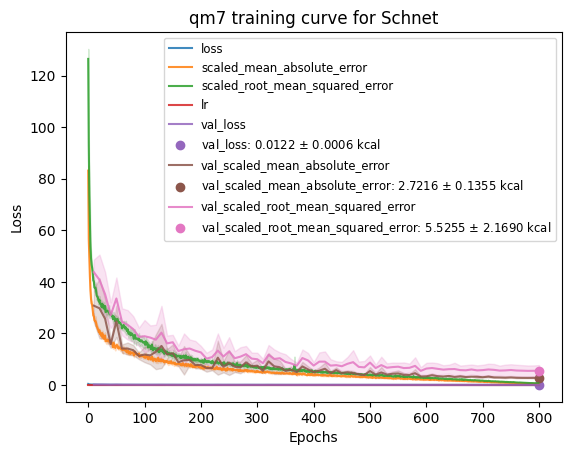

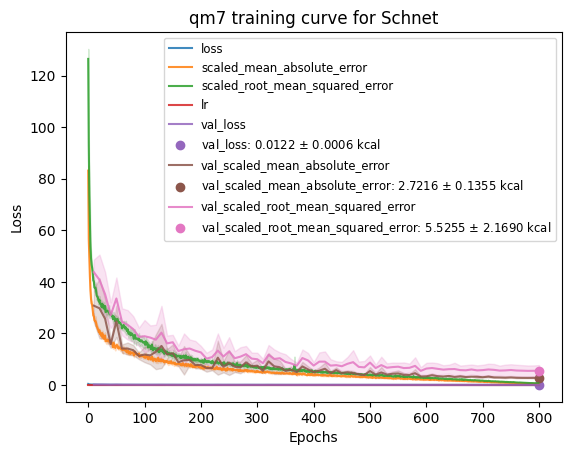

In [14]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="Schnet", data_unit="kcal", dataset_name="qm7",
                     filepath="", file_name=f"loss.png")